In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
from torch.autograd import Variable
import matplotlib.pyplot as plt
torch.manual_seed(1)

In [37]:
# for imbalanced dataset
from torch.utils.data.sampler import WeightedRandomSampler

In [3]:
'''
Load data
'''
# 94 行的Korea, South 手動更改為Korea South
data = np.loadtxt("covid_19.csv",dtype=np.str,delimiter=',')
data = np.delete(data, [0,1,2], 0)
data = np.delete(data, [1,2], 1)
countries = data[:,0]
data = np.delete(data, [0], 1)
print(data.shape) #185 countries,  82days
print(data[0])
data

(185, 82)
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '4' '4' '5' '7' '7' '7' '11' '16'
 '21' '22' '22' '22' '24' '24' '40' '40' '74' '84' '94' '110' '110' '120'
 '170' '174' '237' '273' '281' '299' '349' '367' '423' '444' '484' '521'
 '555' '607']


array([['0', '0', '0', ..., '521', '555', '607'],
       ['0', '0', '0', ..., '416', '433', '446'],
       ['0', '0', '0', ..., '1761', '1825', '1914'],
       ...,
       ['0', '0', '0', ..., '1', '1', '1'],
       ['0', '0', '0', ..., '40', '40', '43'],
       ['0', '0', '0', ..., '13', '14', '14']], dtype='<U32')

In [4]:
diff_data = data.astype(int)
# 計算差值 共有81個差值
for i in range(data.shape[0]):
    for j in range(1,data.shape[1]):
        diff_data[i][j] = data[i][j].astype(int) - data[i][j-1].astype(int)
print(diff_data.shape)
diff_data[0]

(185, 82)


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  1,  2,  0,
        0,  4,  5,  5,  1,  0,  0,  2,  0, 16,  0, 34, 10, 10, 16,  0, 10,
       50,  4, 63, 36,  8, 18, 50, 18, 56, 21, 40, 37, 34, 52])

In [5]:
diff_data = diff_data[:,1:] # 只有81個插值
print(diff_data.shape)

(185, 81)


In [6]:
'''
Correlation coefficient matrix
'''
corrcoef_matrix = np.zeros((len(countries),len(countries)))

for i in range(len(countries)):
    for j in range(len(countries)):
        c1 = diff_data[i].astype(int)
        c2 = diff_data[j].astype(int)
        
        corrcoef_matrix[j][i] = np.corrcoef(c1,c2)[0][1]

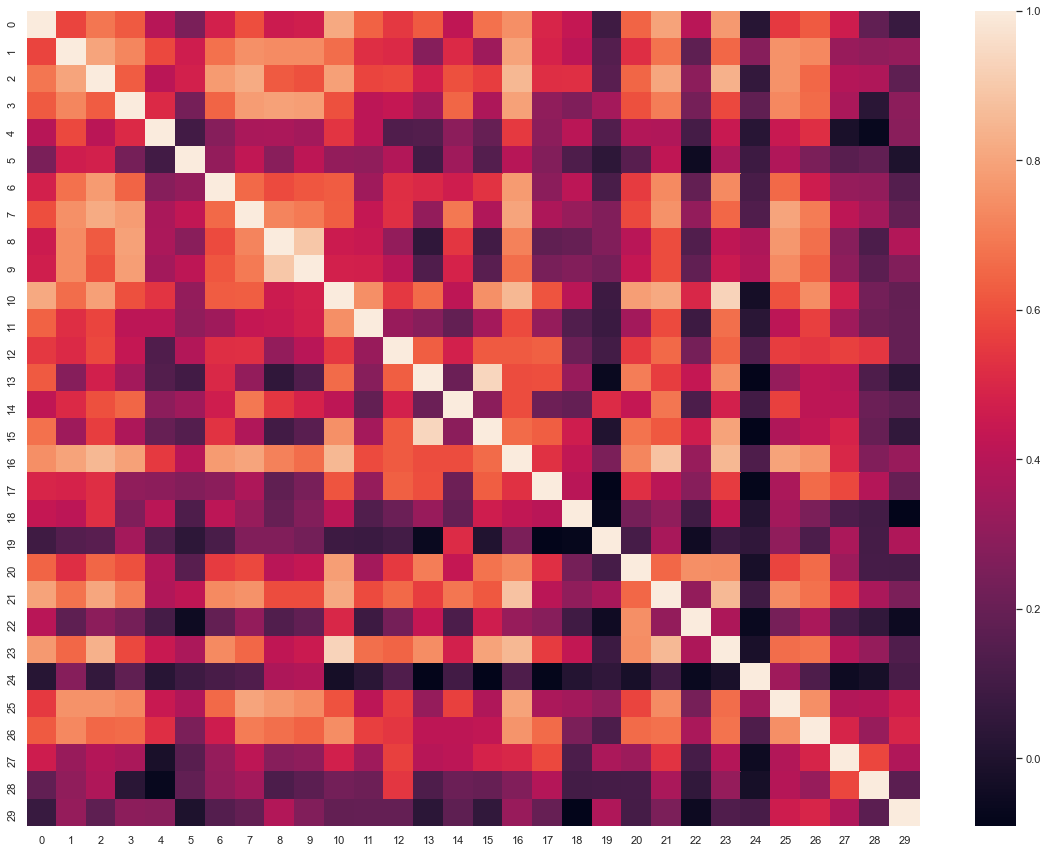

In [7]:
sns.set()
plt.subplots(figsize=(20,15))
sns.heatmap(corrcoef_matrix[:30,:30])

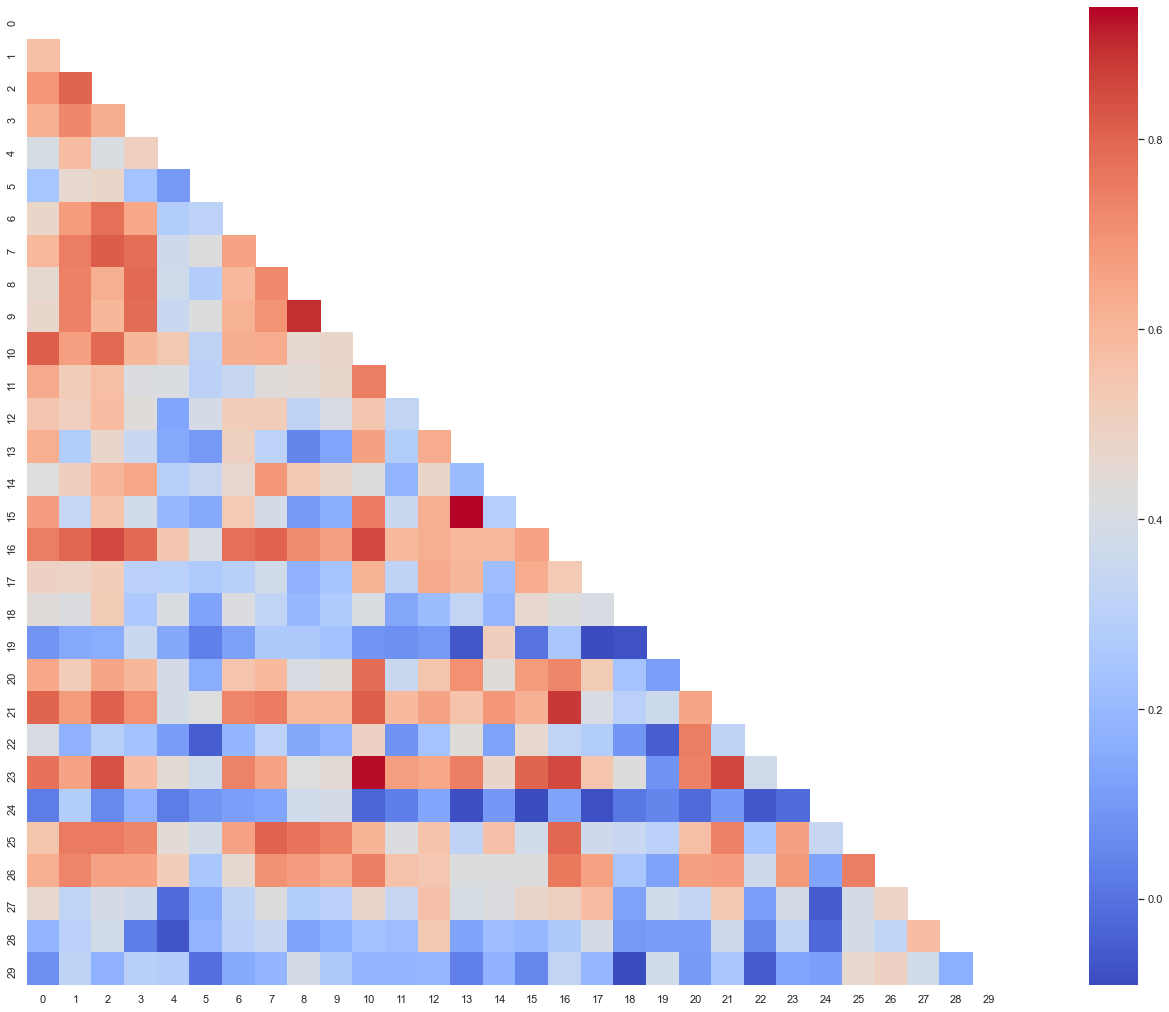

In [8]:
mask = np.zeros_like(corrcoef_matrix[:30,:30])
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(30,18))
    ax = sns.heatmap(corrcoef_matrix[:30,:30], mask=mask, square=True, cmap="coolwarm")

In [77]:
threshold = .4
# 0.70 -> ,0.75 -> ,0.80 -> ,0.85 -> 84,0.90 -> 
length = len(corrcoef_matrix)
country_list = []
for i in range(length):
    for j in range(length):
        if abs(corrcoef_matrix[i][j]) > threshold and i != j:
            country_list.append(i)
            country_list.append(j)
# len(country_list)
C = np.unique(country_list)
len(C), C # 符合threshold的國家

(181,
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 107,
        108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
        147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
        173, 174, 175, 176, 177, 178, 179, 18

In [78]:
'''Generate sequence data'''

L = 3 # interval
print("差值 data shape:", diff_data[C].shape)

C_data = diff_data[C]
seqData, seqLabel = [], []

for i in range(C_data.shape[0]): # 84個國家
    for j in range(C_data.shape[1]-(L)): # 81-5=76 
        x = C_data[i] # i th country
        seqData.append(x[j:j+L].astype(int)) # 會少了最後一個 因為沒有index=81
        seqLabel.append(1 if x[j+L]>x[j+L-1] else 0)

len(seqData), len(seqLabel) # 

差值 data shape: (181, 81)


(14118, 14118)

In [82]:
'''取得不重複的資料：1)確保不重複 2) 確保同資料不會有不同label'''

# 先觀察不重複的資料有多長
uni_list = np.unique(seqData, axis=0)
print("Unique values:", len(uni_list)) # length

# 取得不重複資料以及其label(以第一個的label為主)
seen = set()
unique_seqData = []
unique_seqLabel = []
for i in range(len(seqData)):
    t = tuple(seqData[i])
    if t not in seen:
        unique_seqData.append(seqData[i])
        unique_seqLabel.append(seqLabel[i])
        seen.add(t)
print("Ensure data length:", len(unique_seqData)," is equal to ",len(unique_seqLabel))
print("1 counts:", unique_seqLabel.count(1), ", 0 counts:", unique_seqLabel.count(0))

Unique values: 3688
Ensure data length: 3688  is equal to  3688
1 counts: 1891 , 0 counts: 1797


In [83]:
data = torch.Tensor(unique_seqData)
label = torch.Tensor(unique_seqLabel)

print("Shape of data:",data.shape,", shape of label:",label.shape)
# data, label # seqData, seqLabel as Tensor

Shape of data: torch.Size([3688, 3]) , shape of label: torch.Size([3688])


In [85]:
'''train test split'''
split_ratio = 0.6
trainData = data[:int(len(data)*split_ratio)]
testData = data[int(len(data)*split_ratio):]
trainLabel = label[:int(len(label)*split_ratio)]
testLabel = label[int(len(label)*split_ratio):]
print("train length:",len(trainData),", test length:",len(testData))

train length: 2212 , test length: 1476


In [268]:
input_size = 1 # input 每次的特徵數
seq_length = L # 看幾天 即interval
hidden_size = 64 # 自定義RNN hidden nodes
number_of_layers = 1 # 幾層RNN
batchsize = 8 # 看過幾個資料後更新
epochs = 1000 # 訓練整個資料幾次
learning_rate = 0.001 # learning rate

'''dataset'''
train_dataset = Data.TensorDataset(trainData,trainLabel) # 轉成torch能夠識別的dataset
test_dataset = Data.TensorDataset(testData,testLabel)

'''data loader'''
# 把train dataset放到dataloader裡
loader = Data.DataLoader(
    dataset=train_dataset,      # torch TensorDataset format
    batch_size=batchsize,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    # num_workers=2,              # 多线程来读数据
)

In [269]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(# if use nn.RNN(), it hardly learns
            input_size=input_size,
            hidden_size=64,# rnn hidden unit
            num_layers=1,# number of rnn layer
            batch_first=True,
            # input & output will has batch size as 1s dimension. 
            # e.g. (batch, time_step, input_size) 
        )
        self.sigmoid = nn.Sigmoid()
        self.out = nn.Linear(64, 1)

    def forward(self, x):
        # x shape (batch, time_step, input_size) input x的shape
        # r_out shape (batch, time_step, output_size) output的形狀
        # 會產生兩個hidden state
        # h_n shape (n_layers, batch, hidden_size) 
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :]) # 選取看完第五個以後的output (只取最後一個hidden output)
        final = self.sigmoid(out)
        return final

In [270]:
def calAcc(output, label='train'):
    t = output.detach().numpy()
    pred_y = np.where(t > 0.5, 1, 0).reshape(-1)
    if label == 'train':
        true_y = trainLabel.detach().numpy().astype(int)
    else:
        true_y = testLabel.detach().numpy().astype(int)
    acc = np.sum(true_y == pred_y) / len(pred_y)
    return acc

In [271]:
rnn = RNN()
# print(rnn)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.009)   # optimize all cnn parameters
loss_func = nn.BCELoss() 
print(rnn)

loss_record = []
train_acc_record = []
test_acc_record = []

for epoch in range(epochs):   # 训练所有!整套!数据 3 次
    train_loss = 0
    train_acc = 0
    test_acc = 0

    print("----------------------Starting no.",epoch,"epoch----------------------")
    
    cal_acc_num = 0
    cal_loss_num = 0

    for step, (x, y) in enumerate(loader):  # mini-batch learning
        cal_loss_num += 1
        numofdata = int(x.shape[0]*x.shape[1] / seq_length)
        batch_x = Variable(x.view(numofdata, seq_length, input_size))
        batch_y = Variable(y)

        output = rnn(batch_x)
        loss = loss_func(output, batch_y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            
            cal_acc_num += 1

            print('[step %d at epoch %d]' % (step, epoch))
            print('train loss: %.3f' % loss)
            
            # training
            train_output = rnn(Variable(trainData.view(trainData.shape[0], seq_length, input_size)))
            acc = calAcc(train_output,'train')
            print('train acc: %.3f' % acc)
            train_acc += acc

            # testing
            test_output = rnn(Variable(testData.view(testData.shape[0], seq_length, input_size))) # (samples, time_step, input_size)
            acc = calAcc(test_output,'test')
            print('test acc: %.3f' % acc)
            test_acc += acc
    
    # when an epoch finished... 
    loss_record.append((train_loss/cal_loss_num))
    train_acc_record.append((train_acc/cal_acc_num))
    test_acc_record.append((test_acc/cal_acc_num))

    print('Epoch: ', epoch, '| train loss: %.3f | train acc: %.3f, test acc: %.3f' % (train_loss/cal_loss_num,train_acc/cal_acc_num,test_acc/cal_acc_num))
    

------------------
[step 0 at epoch 944]
train loss: 0.660
train acc: 0.772
test acc: 0.589
[step 100 at epoch 944]
train loss: 0.707
train acc: 0.772
test acc: 0.572
[step 200 at epoch 944]
train loss: 0.298
train acc: 0.765
test acc: 0.596
Epoch:  944 | train loss: 0.417 | train acc: 0.770, test acc: 0.586
----------------------Starting no. 945 epoch----------------------
[step 0 at epoch 945]
train loss: 0.452
train acc: 0.763
test acc: 0.585
[step 100 at epoch 945]
train loss: 0.332
train acc: 0.779
test acc: 0.583
[step 200 at epoch 945]
train loss: 0.234
train acc: 0.775
test acc: 0.595
Epoch:  945 | train loss: 0.391 | train acc: 0.772, test acc: 0.587
----------------------Starting no. 946 epoch----------------------
[step 0 at epoch 946]
train loss: 0.237
train acc: 0.761
test acc: 0.593
[step 100 at epoch 946]
train loss: 0.683
train acc: 0.782
test acc: 0.591
[step 200 at epoch 946]
train loss: 0.496
train acc: 0.780
test acc: 0.573
Epoch:  946 | train loss: 0.381 | train ac

In [272]:
len(loss_record), len(train_acc_record)

(1000, 1000)

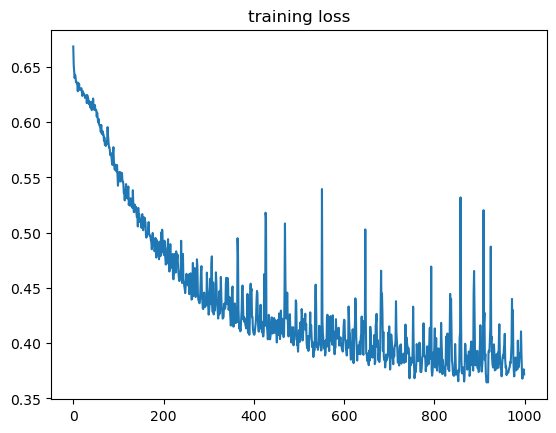

In [277]:
# plot the record
plt.style.use('default')
plt.plot(loss_record)
plt.title("training loss")
plt.show()

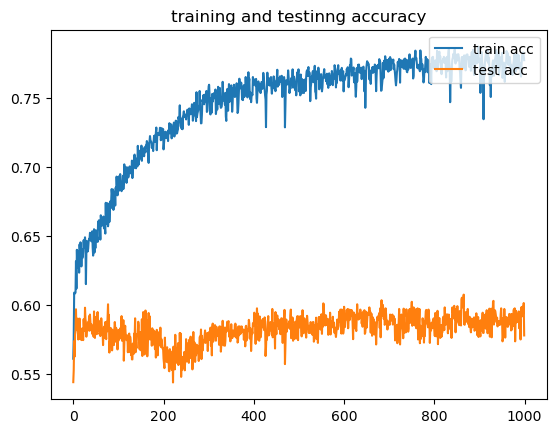

In [276]:
plt.style.use('default')
plt.title("training and testinng accuracy")
plt.plot(train_acc_record, label='train acc')
plt.plot(test_acc_record, label='test acc')
plt.legend(loc='upper right')
plt.show()

In [278]:
import pygal
from pygal.maps.world import World

In [279]:
print(C_data.shape) # ?國家 ?個差值
wmData = C_data[:,-L:]
wmData.shape,type(wmData)

(181, 81)


((181, 3), numpy.ndarray)

In [280]:
wmData = torch.Tensor(wmData)
type(wmData)

torch.Tensor

In [281]:
# wmData
testData.shape, type(testData)

(torch.Size([1476, 3]), torch.Tensor)

In [282]:
wm_pred = rnn(Variable(wmData.view(wmData.shape[0], seq_length, input_size)))
print(type(wm_pred.detach().numpy()))
wm_pred_np = wm_pred.detach().numpy()
wm_pred_np.shape, len(wm_pred_np)

<class 'numpy.ndarray'>


((181, 1), 181)

In [283]:
# 取得country name 共181個
original_data = np.loadtxt("covid_19.csv",dtype=np.str,delimiter=',')
original_data = np.delete(original_data, [0,1,2], 0)
original_data = np.delete(original_data, [1,2], 1)
countries = original_data[:,0]
countries_select = countries[C]
# len(countries_select), countries_select, C # countries的id

In [284]:
a_id, a_name = [], []
d_id, d_name = [], []
for i in range(len(wm_pred_np)):
    if wm_pred_np[i] < 0.5:
        d_id.append(C[i]) # find country id and add it into d
        d_name.append(countries_select[i])
    else:
        a_id.append(C[i]) # find country id and add it into a
        a_name.append(countries_select[i])
print("Length of ascending countries:", len(a_id))
print("Length of descending countries:", len(d_id))

Length of ascending countries: 4
Length of descending countries: 111


In [285]:
from pygal.maps.world import COUNTRIES
def get_country_code(country_name):
    """根据指定的国家，返回pygal使用的两个字母的国别码"""
    for code, name in COUNTRIES.items():
        if name == country_name:
            return code
    # 如果没有找到指定的国家，就返回None
    return None

# worldmap_chart = pygal.maps.world.World()
dict_a = {}
dict_d = {}
# dict_a['af'] = 0.5

# worldmap_chart.add('Ascending',dict_a)
# worldmap_chart.render()
# worldmap_chart.render_to_file('map.svg')

In [287]:
for i in range(len(a_id)):
    country_code = get_country_code(a_name[i])
    if country_code is None:
        print(i, a_id[i])
    else:
        dict_a[country_code] = wm_pred_np[np.where( C == a_id[i])]

    




1
11
16
22
27
42
50
57
67
76
85
87
99


In [167]:
dict_a['cd'] = wm_pred_np[np.where( C == a_id[16])]
dict_a['md'] = wm_pred_np[np.where( C == a_id[46])]
dict_a['tw'] = wm_pred_np[np.where( C == a_id[64])]
# 捨棄1,11,16,24,55 (-5)
len(dict_a) # 70-5 = 65

In [169]:
for i in range(len(d_id)):
    country_code = get_country_code(d_name[i])
    if country_code is None:
        print(i, d[i])
    else:
        dict_d[country_code] = wm_pred_np[np.where( C == d_id[i])]

5 Bahamas
7 Barbados
11 Bolivia
15 Brunei
16 Cabo Verde
21 Congo (Brazzaville)
24 Czechia
27 Dominica
34 Eswatini
35 Fiji
44 Holy See
48 Iran
56 Laos
58 Libya
60 MS Zaandam
70 North Macedonia
77 Russia
78 Saint Kitts and Nevis
79 Saint Lucia
80 Saint Vincent and the Grenadines
89 South Sudan
94 Syria
95 Tanzania
97 Trinidad and Tobago
100 US
104 Venezuela
105 Vietnam
106 West Bank and Gaza


In [170]:
dict_d['bo'] = wm_pred_np[np.where( C == d_id[11])]
dict_d['cg'] = wm_pred_np[np.where( C == d_id[21])]
dict_d['do'] = wm_pred_np[np.where( C == d_id[27])]

dict_d['va'] = wm_pred_np[np.where( C == d_id[44])]
dict_d['ir'] = wm_pred_np[np.where( C == d_id[48])]

dict_d['ly'] = wm_pred_np[np.where( C == d_id[58])]
dict_d['ru'] = wm_pred_np[np.where( C == d_id[77])]

dict_d['sy'] = wm_pred_np[np.where( C == d_id[94])]
dict_d['tz'] = wm_pred_np[np.where( C == d_id[95])]

dict_d['us'] = wm_pred_np[np.where( C == d_id[100])]
dict_d['ve'] = wm_pred_np[np.where( C == d_id[104])]
dict_d['vn'] = wm_pred_np[np.where( C == d_id[105])]

In [171]:
len(dict_d)

94

In [156]:
float(wm_pred_np[1])

0.3777051568031311

In [172]:
worldmap_chart = pygal.maps.world.World()
worldmap_chart.add('Ascending', dict_a)
worldmap_chart.add('Descending', dict_d)

worldmap_chart.render()
worldmap_chart.render_to_file('map.svg')

In [ ]:
# 下面是垃圾

In [21]:
# Number of features used as input. (Number of columns)
INPUT_SIZE = 1
# Number of previous time stamps taken into account.
SEQ_LENGTH = 5
# Number of features in last hidden state ie. number of output time-
# steps to predict.See image below for more clarity.
HIDDEN_SIZE = 1
# Number of stacked rnn layers.
NUM_LAYERS = 1
# We have total of 20 rows in our input. 
# We divide the input into 4 batches where each batch has only 1
# row. Each row corresponds to a sequence of length 5. 
BATCH_SIZE = 4

In [ ]:
# Initialize the RNN.
rnn = nn.RNN(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers = 1, batch_first=True)
# input size : (batch, seq_len, input_size)
inputs = data.view(BATCH_SIZE, SEQ_LENGTH, INPUT_SIZE)
# out shape = (batch, seq_len, num_directions * hidden_size)
# h_n shape  = (num_layers * num_directions, batch, hidden_size)
out, h_n = rnn(inputs)

In [ ]:
print('Input: ', inputs.shape, '\n', inputs)
print('\nOutput: ', out.shape, '\n', out)
print('\nHidden: ', h_n.shape, '\n', h_n)